# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from mogp import MultiOutputMarginal2

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [3]:
N = 50
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

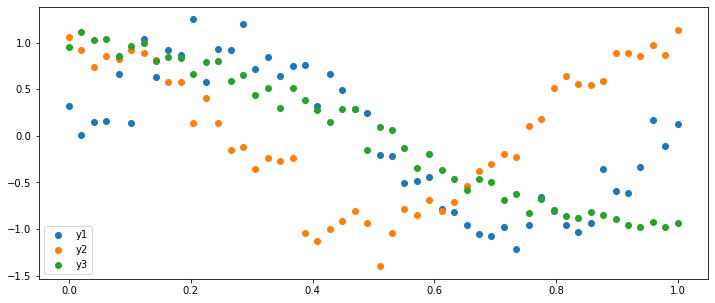

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [8]:
task_i = np.linspace(0, 2, 3)[:, None]
# Xs = [x, task_i] # For training
# Xs[0].shape, Xs[1].shape, x.shape

In [9]:
M = 80
xnew = np.linspace(-0.5, 1.5, M)
Xnew = pm.math.cartesian(xnew, task_i) # For prediction
Xnew.shape

(240, 2)

### 1: Implement ICM (one kernel) by using pm.gp.cov.Kron

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [10]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [11]:
X.shape, y.shape

((150, 2), (150, 1))

In [13]:
import aesara.tensor as at
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal2(means=0, kernels=[cov], num_outputs=3, input_dim=1, B=B)
    y_ = mogp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [15]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 97 seconds.


CPU times: user 4min 38s, sys: 8min 14s, total: 12min 52s
Wall time: 1min 42s


#### Prediction

In [17]:
Xnew.shape

(240, 2)

In [19]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 23.5 s, sys: 27.3 s, total: 50.8 s
Wall time: 7.65 s


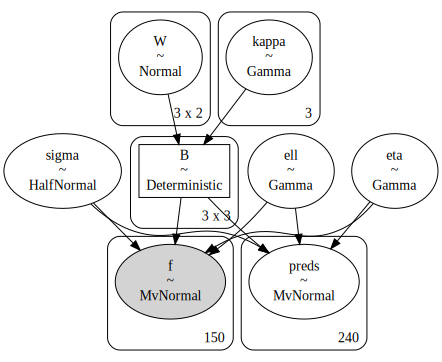

In [20]:
pm.model_to_graphviz(model)

In [22]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 240)

#### Plot the GP prediction

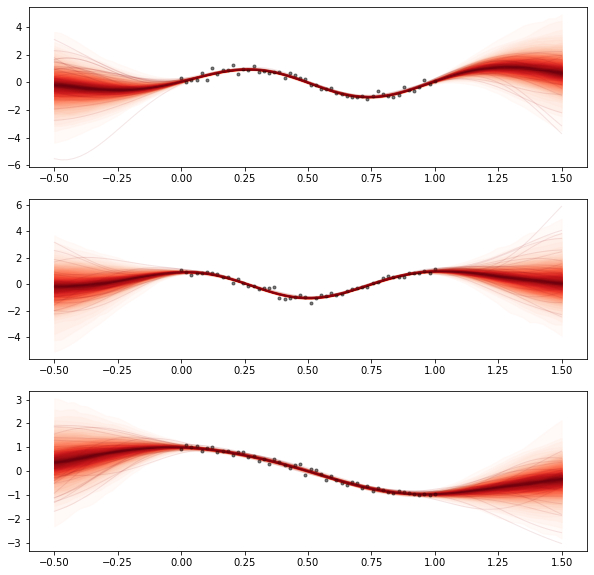

In [23]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [24]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.204,2.118,-3.465,3.753,0.150,0.106,203.0,347.0,NaN
"W[0, 1]",-0.252,2.043,-3.716,3.636,0.112,0.080,314.0,286.0,NaN
"W[1, 0]",0.129,2.015,-3.501,3.783,0.114,0.084,315.0,261.0,NaN
"W[1, 1]",-0.044,2.324,-4.449,3.995,0.136,0.096,294.0,329.0,NaN
"W[2, 0]",-0.048,1.050,-1.855,2.104,0.054,0.045,414.0,285.0,NaN
"W[2, 1]",0.038,0.998,-1.809,2.012,0.043,0.045,510.0,291.0,NaN
ell,0.337,0.044,0.250,0.408,0.002,0.002,296.0,255.0,NaN
eta,0.698,0.301,0.266,1.183,0.020,0.014,239.0,299.0,NaN
kappa[0],1.860,1.263,0.072,3.984,0.051,0.036,436.0,227.0,NaN
kappa[1],1.787,1.419,0.041,4.416,0.072,0.053,323.0,192.0,NaN


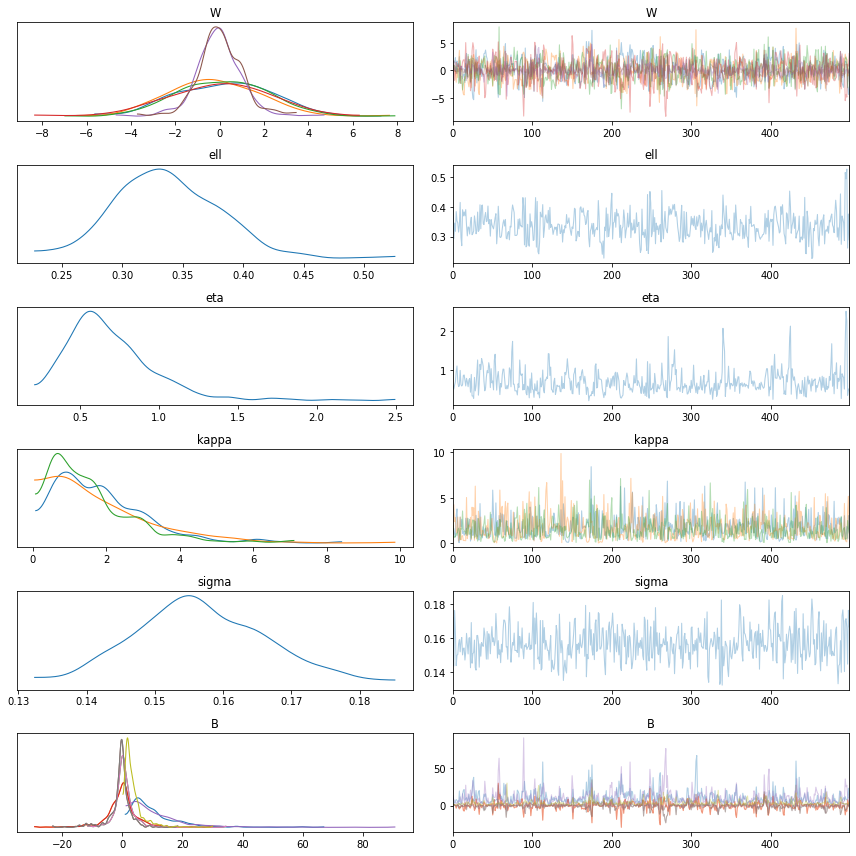

In [25]:
az.plot_trace(gp_trace);
plt.tight_layout()

### 2: Implement LCM by using pm.gp.cov.Kron

$$
K = ( K_{11}(x, x') + K_{12}(x, x') ) \otimes K_2(o, o')
$$

In [26]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [43]:
with pm.Model() as model:    
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(input_dim=1,ls=ell[idx])
                for idx, kernel in enumerate(kernels)]
    
    # Priors for Coregion Matrix
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    
    mogp = MultiOutputMarginal2(means=0, kernels=cov_list, num_outputs=3, input_dim=1, B=B)
    y_ = mogp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)   

In [44]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, W, kappa]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 130 seconds.


CPU times: user 6min 10s, sys: 11min 8s, total: 17min 19s
Wall time: 2min 19s


#### Prediction

In [45]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 29.7 s, sys: 36.8 s, total: 1min 6s
Wall time: 9.79 s


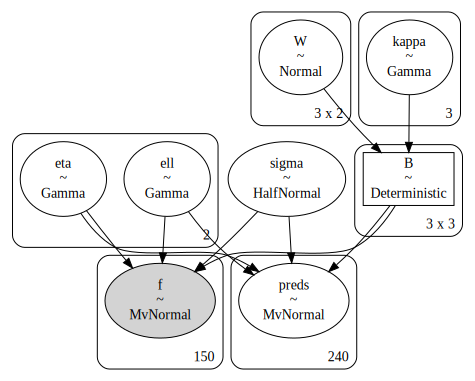

In [46]:
pm.model_to_graphviz(model)

In [47]:
Xnew.shape

(240, 2)

In [48]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 240)

#### Plot the GP prediction

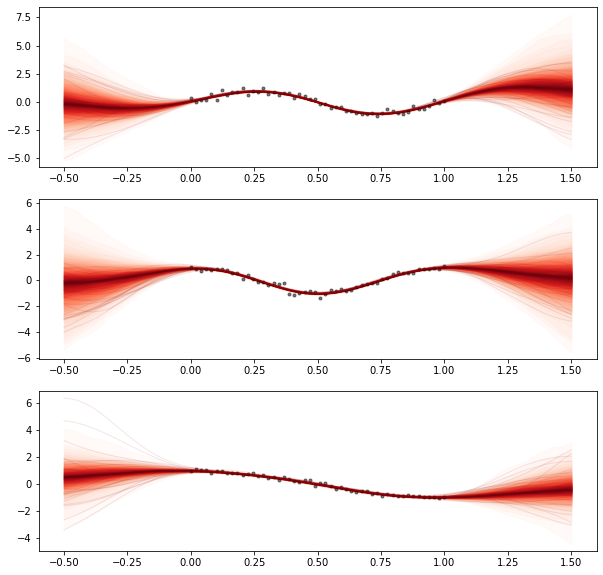

In [49]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [50]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.154,1.988,-4.213,3.439,0.109,0.093,335.0,279.0,NaN
"W[0, 1]",0.009,2.157,-4.055,3.993,0.117,0.098,346.0,259.0,NaN
"W[1, 0]",-0.079,2.027,-4.352,3.924,0.117,0.106,316.0,211.0,NaN
"W[1, 1]",0.061,2.066,-3.765,3.644,0.127,0.092,256.0,305.0,NaN
"W[2, 0]",-0.008,1.031,-2.315,1.988,0.054,0.061,377.0,244.0,NaN
"W[2, 1]",-0.015,0.961,-1.707,1.964,0.044,0.055,491.0,242.0,NaN
ell[0],0.359,0.055,0.258,0.468,0.003,0.002,362.0,346.0,NaN
ell[1],4.744,2.807,0.849,9.798,0.121,0.091,563.0,278.0,NaN
eta[0],0.905,0.396,0.289,1.582,0.022,0.015,311.0,382.0,NaN
eta[1],0.952,0.708,0.047,2.301,0.035,0.026,392.0,245.0,NaN


In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Sep 15 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

matplotlib: 3.5.2
numpy     : 1.22.4
arviz     : 0.12.1
pymc      : 4.1.7

Watermark: 2.3.0

